# Post-meet: Benter 1994 & NFL Data Project

## Data

**“game data.csv”**: Game level summary statistics from pro-football-reference.com. Data columns are:

- `link`: link to page data was scraped from, contains information on relevant team
- `week`: week of game
- `date`: date of game
- `ot`: indicator for if game went to overtime
- `rec`: record of team for that season after the game was completed
- `opp`: opposing team
- `team_score`: points scored
- `opp_score`: points allowed
- `o_fistdown`: first downs gained
- `o_yards`: total yards gained
- `o_passy`: pass yards gained
- `o_rushy`: rush yards gained
- `o_to`: offensive turnovers
- `d_fistdown`: first downs allowed
- `d_yards`: total yards allowed
- `d_passy`: pass yards allowed
- `d_rushy`: rush yards allowed
- `d_to`: defensive turnovers
- `ep_offense`: Offense’s “Expected Points”
- `ep_defense`: Defense’s “Expected Points”
- `ep_st`: Special Teams’ “Expected Points”
- `Team`: the home team (abbreviated)
- `Season`: season the game took place
- `eday`: date the game took place on
- `ha`: indicator if the “Team” is the home or away team
- `OddsOpen`: decimal odds of the “Team” winning at the start of betting (typically 6 days before the game is played)
- `OddsClose`: decimal odds of the “Team” winning right before kickoff
- `LineOpen`: Moneyline for the “Team” winning at the start of betting (typically 6 days before the game is played)
- `LineClose`: Moneyline for the “Team” winning right before kickoff
- `LineOddsOpen`: Payout for the moneyline bet (decimal odds) at start of betting for the “Team”
- `LineOddsClose`: Payout for the moneyline bet (decimal odds) right before kickoff
- `Opponent`: opposing team (abbreviated)
- `game_id`: identifier variable for the game. This is NOT a unique identifier as each game_id should be repeated twice. Observations should be unique by game_id and “Team”
- `take`: take or vigorish for the OddsClose bet
- `win`: 0/1 indicator for if the Team won or not

For all ELO measures see https://projects.fivethirtyeight.com/complete-history-of-the-nfl/

## Setup

In [249]:
import os
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize_scalar


# To avoid time conversion issues
os.environ['TZ'] = 'UTC'

In [90]:
class Bundle(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __setattr__(self, key, value):
        self[key] = value

In [91]:
filename = "Data Project NFL/clean NFL.csv"
# Load the data from the CSV file
raw = pd.read_csv(filename)
print(raw.shape)
raw.head().T

(3584, 38)


,0,1,2,3,4
week,1,2,3,4,5
date,September 07,September 14,September 18,September 28,October 05
ot,OT,NaN,NaN,NaN,NaN
rec,1-0,1-1,2-1,2-2,2-3
opp,New Orleans Saints,Cincinnati Bengals,Tampa Bay Buccaneers,Minnesota Vikings,New York Giants
team_score,37.0,10.0,56.0,28.0,20.0
opp_score,34.0,24.0,14.0,41.0,30.0
o_fistdown,28.0,19.0,26.0,23.0,20.0
o_yards,568.0,309.0,488.0,411.0,397.0
o_passy,445.0,212.0,344.0,288.0,307.0


## EDA (Exploratory Data Analysis)

In [4]:
raw.dtypes

week               int64
date              object
ot                object
rec               object
opp               object
team_score       float64
opp_score        float64
o_fistdown       float64
o_yards          float64
o_passy          float64
o_rushy          float64
o_to               int64
d_fistdown       float64
d_yards          float64
d_passy          float64
d_rushy          float64
d_to               int64
ep_offense       float64
ep_defense       float64
ep_st            float64
Team              object
season             int64
eday              object
ha                object
OddsOpen         float64
OddsClose        float64
LineOpen         float64
LineClose        float64
LineOddsOpen     float64
LineOddsClose    float64
Opponent          object
game_id            int64
elo              float64
elo_prob         float64
qbelo            float64
qbelo_prob       float64
take             float64
win                int64
dtype: object

In [5]:
nulls = raw.isna().sum().sort_values(ascending=False)
pd.Series({n: ", ".join(nulls[nulls == n].index.tolist()) for n in nulls.unique()})
# print(nulls)

3414                                                   ot
386     ep_st, LineOddsClose, LineClose, LineOpen, Odd...
0       qbelo_prob, elo_prob, elo, game_id, take, week...
dtype: object

In [6]:
raw.ot.value_counts(dropna=False)

NaN    3414
OT      170
Name: ot, dtype: int64

We expect `OT` to be a boolean flag, instead it's "OT" or None. Must encode correctly. But first let look at the rest of NaNs.

Then there's apparently a set of 386 records with no data for a lot of fields. Grouping by season, we can see they're all from the 2020 season:

In [7]:
raw.season.value_counts()

2014    512
2015    512
2016    512
2017    512
2018    512
2019    512
2020    512
Name: season, dtype: int64

In [8]:
raw.groupby(["season"]).apply(lambda x: x.isna().sum()).round(2).T.head(10)

season,2014,2015,2016,2017,2018,2019,2020
week,0,0,0,0,0,0,0
date,0,0,0,0,0,0,0
ot,490,470,486,484,482,494,508
rec,0,0,0,0,0,0,386
opp,0,0,0,0,0,0,0
team_score,0,0,0,0,0,0,386
opp_score,0,0,0,0,0,0,386
o_fistdown,0,0,0,0,0,0,386
o_yards,0,0,0,0,0,0,386
o_passy,0,0,0,0,0,0,386


Not _every_ game from 2020 season has no data, let's look at per-week stats:

In [9]:
raw[raw.season == 2020].groupby(["week"]).apply(lambda x: x.isna().sum()).round(2).T.tail(10)

week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
LineOddsOpen,0,0,0,0,30,28,28,28,28,28,26,32,30,32,32,32,32
LineOddsClose,0,0,0,0,30,28,28,28,28,28,26,32,30,32,32,32,32
Opponent,0,0,0,0,30,28,28,28,28,28,26,32,30,32,32,32,32
game_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
elo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
elo_prob,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
qbelo,0,0,0,0,30,28,28,28,28,28,26,32,30,32,32,32,32
qbelo_prob,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
take,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
win,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


From week 4 onwards, the data is missing, but the response variable `win` is never empty. Let's see its value distribution.

In [10]:
raw[(raw.season == 2020) & (raw.week >= 5)].win.value_counts(dropna=False)

0    386
Name: win, dtype: int64

No chance _both_ teams lost every match after week 5, this is a zero-value where a NaN value should have been. 

In [17]:
raw.groupby(raw.team_score.isna()).apply(lambda x: x.isna().mean()).round(
    2
).T.sort_values(by=False, ascending=False).head(10)

team_score,False,True
ot,0.95,1.0
week,0.00,0.0
LineOddsClose,0.00,1.0
eday,0.00,0.0
ha,0.00,1.0
OddsOpen,0.00,1.0
OddsClose,0.00,1.0
LineOpen,0.00,1.0
LineClose,0.00,1.0
LineOddsOpen,0.00,1.0


Games with a value for `team_score`, only have `ot` missing (which we know already), and all other fields are present. _Every_ game without a `team_score` value, neither has any of the other missing fields, and although they have a `win` value, it's not significant.

**We'll drop every row without `team_score`, which should delete 386 rows:**


In [18]:
data = raw[raw.team_score.notna()].copy()
assert len(raw) - 386 == len(data)

In [19]:
data["ot"] = data["ot"].notna()

In [20]:
# Convert the 'eday' column to datetime dtype
data["raw_date"] = data.date
data['date'] = pd.to_datetime(data['eday'], format='%d%b%Y')
# Convert the datetime objects to Unix timestamps
data['ts'] = data.date.astype(int) // 10**9

data[["raw_date", "eday", "date", "ts"]].head()

,raw_date,eday,date,ts
0,September 07,07sep2014,2014-09-07,1410048000
1,September 14,14sep2014,2014-09-14,1410652800
2,September 18,18sep2014,2014-09-18,1410998400
3,September 28,28sep2014,2014-09-28,1411862400
4,October 05,05oct2014,2014-10-05,1412467200


In [21]:
from datetime import datetime

assert [
    datetime.fromtimestamp(timestamp) for timestamp in data.ts
] == data.date.tolist()

In [22]:
# Convert `rec` to three separate fields
# data[["win", "loss", "tie"]] = data['rec'].str.split("-",expand=True).fillna(0).astype(int)

In [23]:
assert sorted(data.ha.unique()) == ["A", "H"]  # Exclude any third options
data["H"] = data.ha == "H"

In [24]:
for x in ["o", "d"]:
    assert np.all(data[x + "_yards"] == data[x + "_passy"] + data[x + "_rushy"])

Even then, we'll keep the three and let the estimator decide on the better representation.

In [25]:
assert data[data.H].shape == data[~data.H].shape
data[data.H].shape, data[~data.H].shape

((1599, 41), (1599, 41))

In [26]:
data["diff_score"] = data.team_score - data.opp_score
data["signed_win"] = np.sign(data.diff_score)

In [27]:
data[["win", "signed_win"]].value_counts()

win  signed_win
0    -1.0          1592
1     1.0          1592
0     0.0            14
dtype: int64

## Feature Engineering

Every `week` of every `season`, several `games` between a `home_team` and an `away_team` happen. Some of the features available are particular to the match itself, including the betting odds and line odds:

In [28]:
stats_cols = [
    "diff_score",
    "team_score",
    "opp_score",
    "o_fistdown",
    "o_yards",
    "o_passy",
    "o_rushy",
    "o_to",
    "d_fistdown",
    "d_yards",
    "d_passy",
    "d_rushy",
    "d_to",
    "ep_offense",
    "ep_defense",
    "ep_st",
    "elo",
    "elo_prob",
    "qbelo",
    "qbelo_prob",
    "win",
]
betting_cols = [
    "OddsOpen",
    "OddsClose",
    "LineOpen",
    "LineClose",
    "LineOddsOpen",
    "LineOddsClose",
]

TODO: `stats_cols` include a lot of "post-game" metrics that you only know after the _end_ of the match, and cannot be used as features to predict the outcome (`[team|opp]_score, [o|d]_[yards|passy|rushy|fistdown|to]`), and some that look like "pre-game" stats about each team (`ep_[offense|defense|st], (qb)elo(_prob)`). We should clearly differentiate between the two, and keep the latter (instead of dropping them all) as prediction features.

For each match, we'll create two set of features, for the home (`home_`) and away (`away_`) teams. For each , match, "base feature" (i.e. each column in `stats_cols`) and home/away team, we'll calculate:
- the last value against any other team (`vsall_last_`),
- the historical average against any other team, up until last match included (`vsall_avg_`)
- the last value against the same opponent (`vsopp_last_`),
- the historical average against the same opponent, up until last match included (`vsopp_avg_`)
- the season average, up until last match included (`season_avg_`)

We do not include `season_last_` features, because except for the first match of the season it's identical to `vsall_last_`.


In [29]:
key = ["season", "week", "Opponent", "Team"]
data = data.sort_values(by=key)
vsall = data.groupby("Team", group_keys=False)[stats_cols]
vsopp = data.groupby(["Opponent", "Team"], group_keys=False)[stats_cols]
season = data.groupby(["season", "Team"], group_keys=False)[stats_cols]

In [30]:
feats = pd.concat(
    [
        data[key + betting_cols],
        # Last game stats
        vsall.shift().add_prefix("vsall_last_"),
        # Historical stats average (expanding.mean) up to last game (shift)
        vsall.apply(lambda x: x.shift().expanding().mean()).add_prefix("vsall_avg_"),
        # Sames as before, but exclusively against the current opponen
        vsopp.shift().add_prefix("vsopp_last_"),
        vsopp.apply(lambda x: x.shift().expanding().mean()).add_prefix("vsopp_avg_"),
        season.apply(lambda x: x.shift().expanding().mean()).add_prefix("season_avg_"),
    ],
    axis=1,
).set_index(key)

In [31]:
match_cols = key + ["date", "ts", "ot"]

In [32]:
if "game_id" in data.columns:
    data = data.set_index("game_id").sort_index()
home, away = data[data.H], data[~data.H]
assert len(home) == len(away) == len(data) / 2
assert np.all(home.index == away.index)

In [33]:
home_feats = home[key].reset_index().set_index(key).join(feats).set_index("game_id").sort_index()
away_feats = away[key].reset_index().set_index(key).join(feats).set_index("game_id").sort_index()

In [42]:
X = home[match_cols].sort_index().join(
    home_feats.add_prefix("home_")
).join(away_feats.add_prefix("away_")).sort_index()

In [43]:
over_spread = np.array([
    (home.team_score + home.LineClose > home.opp_score).mean(),
    (away.team_score + away.LineClose > away.opp_score).mean(),
    (home.opp_score + away.LineClose > home.team_score).mean(),
]).round(3)
over_spread

array([0.467, 0.502, 0.502])

In [44]:
home[match_cols]

,season,week,Opponent,Team,date,ts,ot
game_id,,,,,,,
2137,2014,1,gnb,sea,2014-09-04,1409788800,False
2138,2014,1,nwe,mia,2014-09-07,1410048000,False
2139,2014,1,cin,rav,2014-09-07,1410048000,False
2140,2014,1,nor,atl,2014-09-07,1410048000,True
2141,2014,1,sfo,dal,2014-09-07,1410048000,False
...,...,...,...,...,...,...,...
3797,2020,4,clt,chi,2020-10-04,1601769600,False
3798,2020,4,buf,rai,2020-10-04,1601769600,False
3799,2020,4,phi,sfo,2020-10-04,1601769600,False


## Modelling

Benter:
> The type of model used by the author is the **multinomial logit** model proposed by Bolton and Chapman (1986). This model is well suited to horse racing and has the convenient property that its output is a **set of probability estimates which sum to 1 within each race**.

There are eight possible bets to make on every game:
$$ \text{Bet on the [money, spread] line for the [home, away] team @ book [open, close]}$$

To bet on any of those, we need an estimate of the probability of winning the event. There are several ways to do so. In no particular order, here are some possible models:

#### 1. "Trinomial" Signed Lines
For every "line" (money or spread), one of three things can happen: home wins, draw/push, away wins. One can then train such "trinomial" response (with a logit as Benter, or any other model that outputs probabilities for each class) for every line available (money, open spread, close spread), using the same set of observations, one for each match.
- Pros: very straightforward to implement
- Cons: loses information by not differentiating between a big (say, +20) and small (+2) win over the line.

#### 2. Parametric Point Scores
Instead of directly predicting bet's winning probabilities, we first explicitly model the point scoring distribution for both teams, and then derive a closed-form distribution for the point difference of every game. [Maher (1982)](http://www.90minut.pl/misc/maher.pdf), [Dixon & Coles (1997)](https://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf) do so for soccer games rather convincingly, representing the home and away scores essentially as Poisson RVs.
- Pros: allows for explicit mean/variance calculations about the game scores; provides ways of computing money, total and spread line odds.
- Cons: No obvious parametric distribution to fit even soccer scores (with +1 point increments), less so for american football.

#### 3. Score Difference PMF
Having no "total" line, the money and spread bets winning probabilities can be found knowing just the score difference distribution, which can be thought of as a discrete RV assuming integer values between `min_diff, max_diff`. Then, the probability of winning a bet with $L$ line, is
$$ P(diff > L) = \sum_{k>L} P(diff=k)$$
- Pros: Very few assumptions, any nonparametric classifier which outputs class probabilities would do.
- Cons: There are a _lot_ of possible lines. Even a [0.05, 0.95] quantile range is `[-22, 27]` in the dataset, for a total of 50 outcomes to train on just ~1.6K games

### 4. Score Difference CDF
Instead of finding the full PMF for the score difference $diff$ as in Model #3 ($P(diff=k)$ for every $k$), we could directly estimate the quantities of interest $P(diff > L) = 1 - F(L)$, where $F$ is the cumulative distribution function for $diff$. To that end, for every possible line $L$, we train a binary classifier, on the outcome $diff > L$, with every game available.
- Pros: Gives direct probabilities of winning any money/spread bet (money bets == spread bets with +-0 line).
- Cons: We need to train 50+ classifiers, one for each "step" on the CDF "ladder".

We'll go for Model #1, not because of any intrinsic merit, but due to a lack of time to explore other alternatives.

In [45]:
home.diff_score.describe(percentiles=[0.05, 0.95])

count    1599.000000
mean        1.821764
std        14.354579
min       -49.000000
5%        -22.000000
50%         3.000000
95%        27.000000
max        52.000000
Name: diff_score, dtype: float64

In [46]:
home.diff_score.value_counts().head(8)

 3.0     130
-3.0      94
 7.0      82
-7.0      67
 6.0      55
 10.0     51
-6.0      50
 14.0     48
Name: diff_score, dtype: int64

In [47]:
# "Signed" Responses
Y = pd.DataFrame(Bundle(
    win=np.sign(home.team_score - home.opp_score),
    open_spread=np.sign(home.team_score + home.LineOpen - home.opp_score),
    close_spread=np.sign(home.team_score + home.LineClose - home.opp_score),
))

In [48]:
Y.value_counts()

win   open_spread  close_spread
 1.0   1.0          1.0            662
-1.0  -1.0         -1.0            608
 1.0  -1.0         -1.0            159
-1.0   1.0          1.0             51
 1.0  -1.0          0.0             17
-1.0  -1.0          1.0             12
 1.0   0.0         -1.0             12
-1.0  -1.0          0.0             11
 1.0  -1.0          1.0             11
       1.0         -1.0             10
       0.0          0.0              9
       1.0          0.0              7
-1.0   1.0         -1.0              6
       0.0          0.0              4
                    1.0              4
 0.0  -1.0         -1.0              4
 1.0   0.0          1.0              4
-1.0   0.0         -1.0              3
 0.0   1.0          1.0              2
-1.0   1.0          0.0              2
 0.0  -1.0          1.0              1
dtype: int64

In [49]:
X.shape, Y.shape

((1599, 229), (1599, 3))

In [50]:
first_season = data.season.min()
starting_elo = (
    data[(data.season == first_season) & (data.week == 1)][["Team", "elo"]]
    .set_index("Team")
    .elo
)
team_rank = starting_elo.rank().astype(int)

In [51]:
# TODO: Move this to the "Feature Engineering" section.
X["team_rank"] = team_rank[X.Team].values
X["opp_rank"] = team_rank[X.Opponent].values
X = X.drop(columns=["Team", "Opponent", "date"])


## Estimation / Model Training

In [53]:
# Load the historical match data for the team
# Split the data into training and testing sets
(
    X_train,
    X_test,
    Y_train,
    Y_test,
) = train_test_split(X, Y, test_size=0.2, random_state=42)

In [54]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1279, 228), (320, 228), (1279, 3), (320, 3))

In [56]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define the search space for the hyperparameters
search_space = {
    "num_leaves": Integer(2, 10),
    "learning_rate": Real(0.01, 0.25),
    "feature_fraction": Real(0.5, 1.0),
    "num_iterations": Integer(50, 500),
    "lambda_l1": Real(0, 10),
    "lambda_l2": Real(0, 10),
}

# Define the LightGBM parameters
params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
}

# Define the BayesSearchCV object for each model
search_params = Bundle(
    estimator=lgb.LGBMClassifier(**params),
    search_spaces=search_space,
    n_iter=30,
    cv=3,
    n_jobs=-1,
    scoring="f1_weighted",  # TODO: Consider pros/cons of "neg_log_loss", "accuracy"
    random_state=42,
)


In [61]:
[y for y in Y.columns if y != "win"]

['open_spread', 'close_spread']

In [63]:
ys = ["win", "open_spread", "close_spread"]
models = Bundle({y: BayesSearchCV(**search_params).fit(X_train, Y_train[y]) for y in Y})
# models.win.fit(X_train, Y_train.win)
# models.open_spread.fit(X_train, Y_train.open_spread)
# models.close_spread.fit(X_train, close_spread_train)

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warning] lambda_l2 is set=9.328679988478338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.328679988478338
[LightGBM] [Warning] lambda_l1 is set=7.277257431773251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.277257431773251
[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warning] lambda_l2 is set=9.328679988478338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.328679988478338
[LightGBM] [Warning] lambda_l1 is set=7.277257431773251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.277257431773251
[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warnin

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warning] lambda_l2 is set=3.03410109884175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03410109884175
[LightGBM] [Warning] lambda_l1 is set=8.833152773808623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.833152773808623


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warning] lambda_l2 is set=3.03410109884175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03410109884175
[LightGBM] [Warning] lambda_l2 is set=3.03410109884175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03410109884175
[LightGBM] [Warning] lambda_l1 is set=8.833152773808623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.833152773808623
[LightGBM] [Warning] lambda_l1 is set=8.833152773808623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.833152773808623


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=1.0485915855270358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0485915855270358
[LightGBM] [Warning] lambda_l1 is set=9.18722521669377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.18722521669377
[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=1.0485915855270358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0485915855270358
[LightGBM] [Warning] lambda_l1 is set=9.18722521669377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.18722521669377


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=1.0485915855270358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0485915855270358
[LightGBM] [Warning] lambda_l1 is set=9.18722521669377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.18722521669377


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGBM] [Warning] lambda_l2 is set=5.9804707751212804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9804707751212804
[LightGBM] [Warning] lambda_l1 is set=1.718715613965607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718715613965607
[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGBM] [Warning] lambda_l2 is set=5.9804707751212804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9804707751212804
[LightGBM] [Warning] lambda_l1 is set=1.718715613965607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718715613965607


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGBM] [Warning] lambda_l2 is set=5.9804707751212804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9804707751212804
[LightGBM] [Warning] lambda_l1 is set=1.718715613965607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718715613965607


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [Warning] lambda_l2 is set=5.266202371276925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.266202371276925
[LightGBM] [Warning] lambda_l1 is set=4.380291864409234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380291864409234
[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [Warning] lambda_l2 is set=5.266202371276925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.266202371276925
[LightGBM] [Warning] lambda_l1 is set=4.380291864409234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380291864409234


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [Warning] lambda_l2 is set=5.266202371276925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.266202371276925
[LightGBM] [Warning] lambda_l1 is set=4.380291864409234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380291864409234


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGBM] [Warning] lambda_l2 is set=1.6360717863855025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6360717863855025
[LightGBM] [Warning] lambda_l1 is set=9.393697376027717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.393697376027717
[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGBM] [Warning] lambda_l2 is set=1.6360717863855025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6360717863855025
[LightGBM] [Warning] lambda_l1 is set=9.393697376027717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.393697376027717
[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGBM] [Warning] lambda_l2 is set=3.5902293192140395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5902293192140395
[LightGBM] [Warning] lambda_l1 is set=7.753643788278826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753643788278826
[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGBM] [Warning] lambda_l2 is set=3.5902293192140395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5902293192140395
[LightGBM] [Warning] lambda_l1 is set=7.753643788278826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753643788278826
[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [Warning] lambda_l2 is set=4.964667035967167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.964667035967167
[LightGBM] [Warning] lambda_l1 is set=9.200092264373165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200092264373165
[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [Warning] lambda_l2 is set=4.964667035967167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.964667035967167
[LightGBM] [Warning] lambda_l1 is set=9.200092264373165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200092264373165
[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning] lambda_l2 is set=8.71651928463215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71651928463215
[LightGBM] [Warning] lambda_l1 is set=7.00621444621366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.00621444621366
[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning] lambda_l2 is set=8.71651928463215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71651928463215
[LightGBM] [Warning] lambda_l1 is set=7.00621444621366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.00621444621366
[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning]

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [Warning] lambda_l2 is set=7.412827443680273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.412827443680273
[LightGBM] [Warning] lambda_l1 is set=8.178300196637515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.178300196637515
[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [Warning] lambda_l2 is set=7.412827443680273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.412827443680273
[LightGBM] [Warning] lambda_l1 is set=8.178300196637515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.178300196637515
[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7471525251651421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7471525251651421
[LightGBM] [Warning] lambda_l2 is set=3.963872883457346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.963872883457346
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.7471525251651421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7471525251651421
[LightGBM] [Warning] lambda_l2 is set=3.963872883457346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.963872883457346
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.7471525251651421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7471525251651421
[LightGBM] [Warning] lambda_l2 is set=3.963872883457346, reg_lam

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8038800152448076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8038800152448076
[LightGBM] [Warning] lambda_l2 is set=1.2980769982601992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2980769982601992
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8038800152448076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8038800152448076
[LightGBM] [Warning] lambda_l2 is set=1.2980769982601992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2980769982601992
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8038800152448076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8038800152448076
[LightGBM] [Warning] lambda_l2 is set=1.2980769982601992, reg_la

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8130660230091358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8130660230091358
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.4940797592540865e-18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4940797592540865e-18
[LightGBM] [Warning] feature_fraction is set=0.8130660230091358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8130660230091358
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.4940797592540865e-18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4940797592540865e-18
[LightGBM] [Warning] feature_fraction is set=0.8130660230091358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8130660230091358
[LightGBM] [Warning] lambda_l2 is set=10.0, 

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7599046234766829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7599046234766829
[LightGBM] [Warning] lambda_l2 is set=3.826838161700242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.826838161700242
[LightGBM] [Warning] lambda_l1 is set=6.046356472880651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.046356472880651
[LightGBM] [Warning] feature_fraction is set=0.7599046234766829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7599046234766829
[LightGBM] [Warning] lambda_l2 is set=3.826838161700242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.826838161700242
[LightGBM] [Warning] lambda_l1 is set=6.046356472880651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.046356472880651
[LightGBM] [Warning] feature_fraction is set=0.7599046234766829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7599046234766829
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=4.241136502200377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.241136502200377
[LightGBM] [Warning] lambda_l1 is set=7.583839561113037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.583839561113037
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=4.241136502200377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.241136502200377
[LightGBM] [Warning] lambda_l1 is set=7.583839561113037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.583839561113037
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=4.241136502200377, reg_lambda=0.0 will be ignored. Current value

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.3636755051041725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3636755051041725
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.3636755051041725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3636755051041725
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.3636755051041725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3636755051041725
[LightGBM] [Warn

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6111544714974603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111544714974603
[LightGBM] [Warning] lambda_l2 is set=4.082850209663818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.082850209663818
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.6111544714974603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111544714974603
[LightGBM] [Warning] lambda_l2 is set=4.082850209663818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.082850209663818
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.6111544714974603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6111544714974603
[LightGBM] [Warning] lambda_l2 is set=4.082850209663818, reg_lam

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.504087360334463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.504087360334463
[LightGBM] [Warning] lambda_l2 is set=5.154726386662302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.154726386662302
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.504087360334463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.504087360334463
[LightGBM] [Warning] lambda_l2 is set=5.154726386662302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.154726386662302
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.504087360334463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.504087360334463
[LightGBM] [Warning] lambda_l2 is set=5.154726386662302, reg_lambda=0.

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9191357842810544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9191357842810544
[LightGBM] [Warning] lambda_l2 is set=9.776475319441403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.776475319441403
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.9191357842810544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9191357842810544
[LightGBM] [Warning] lambda_l2 is set=9.776475319441403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.776475319441403
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.9191357842810544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9191357842810544
[LightGBM] [Warning] lambda_l2 is set=9.776475319441403, reg_lambda=

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9190620122786544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190620122786544
[LightGBM] [Warning] lambda_l2 is set=1.1142388524542703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1142388524542703
[LightGBM] [Warning] lambda_l1 is set=0.8344579900681349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8344579900681349
[LightGBM] [Warning] feature_fraction is set=0.9190620122786544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190620122786544
[LightGBM] [Warning] lambda_l2 is set=1.1142388524542703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1142388524542703
[LightGBM] [Warning] lambda_l1 is set=0.8344579900681349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8344579900681349
[LightGBM] [Warning] feature_fraction is set=0.9190620122786544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190620122786544
[Lig

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7045957157690184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7045957157690184
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=3.1092049918014935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1092049918014935
[LightGBM] [Warning] feature_fraction is set=0.7045957157690184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7045957157690184
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=3.1092049918014935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1092049918014935
[LightGBM] [Warning] feature_fraction is set=0.7045957157690184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7045957157690184
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will b

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5094029327598968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5094029327598968
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5094029327598968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5094029327598968
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5094029327598968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5094029327598968
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM]

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.553779503430611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553779503430611
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.553779503430611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553779503430611
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.553779503430611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553779503430611
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] l

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9001732691851903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001732691851903
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=8.210698928515527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.210698928515527
[LightGBM] [Warning] feature_fraction is set=0.9001732691851903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001732691851903
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=8.210698928515527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.210698928515527
[LightGBM] [Warning] feature_fraction is set=0.9001732691851903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001732691851903
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will 

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5752027384378398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752027384378398
[LightGBM] [Warning] lambda_l2 is set=2.591634181443698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.591634181443698
[LightGBM] [Warning] lambda_l1 is set=0.052945865272152996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052945865272152996
[LightGBM] [Warning] feature_fraction is set=0.5752027384378398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752027384378398
[LightGBM] [Warning] lambda_l2 is set=2.591634181443698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.591634181443698
[LightGBM] [Warning] lambda_l1 is set=0.052945865272152996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052945865272152996
[LightGBM] [Warning] feature_fraction is set=0.5752027384378398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752027384378398


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=2.740292121809106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.740292121809106
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=2.740292121809106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.740292121809106
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=2.74029212

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.3636755051041725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3636755051041725
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warning] lambda_l2 is set=9.328679988478338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.328679988478338
[LightGBM] [Warning] lambda_l1 is set=7.277257431773251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.277257431773251
[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warning] lambda_l2 is set=9.328679988478338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.328679988478338
[LightGBM] [Warning] lambda_l1 is set=7.277257431773251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.277257431773251
[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warnin

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warning] lambda_l2 is set=3.03410109884175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03410109884175
[LightGBM] [Warning] lambda_l1 is set=8.833152773808623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.833152773808623
[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warning] lambda_l2 is set=3.03410109884175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03410109884175
[LightGBM] [Warning] lambda_l1 is set=8.833152773808623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.833152773808623
[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warn

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=1.0485915855270358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0485915855270358
[LightGBM] [Warning] lambda_l1 is set=9.18722521669377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.18722521669377
[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=1.0485915855270358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0485915855270358
[LightGBM] [Warning] lambda_l1 is set=9.18722521669377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.18722521669377
[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGBM] [Warning] lambda_l2 is set=5.9804707751212804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9804707751212804
[LightGBM] [Warning] lambda_l1 is set=1.718715613965607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718715613965607
[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGBM] [Warning] lambda_l2 is set=5.9804707751212804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9804707751212804
[LightGBM] [Warning] lambda_l1 is set=1.718715613965607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718715613965607
[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [Warning] lambda_l2 is set=5.266202371276925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.266202371276925
[LightGBM] [Warning] lambda_l1 is set=4.380291864409234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380291864409234
[LightGBM] [Warning] lambda_l2 is set=5.266202371276925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.266202371276925
[LightGBM] [Warning] lambda_l1 is set=4.380291864409234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380291864409234
[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGBM] [Warning] lambda_l2 is set=1.6360717863855025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6360717863855025
[LightGBM] [Warning] lambda_l1 is set=9.393697376027717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.393697376027717
[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGBM] [Warning] lambda_l2 is set=1.6360717863855025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6360717863855025
[LightGBM] [Warning] lambda_l1 is set=9.393697376027717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.393697376027717
[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGBM] [Warning] lambda_l2 is set=3.5902293192140395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5902293192140395
[LightGBM] [Warning] lambda_l1 is set=7.753643788278826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753643788278826
[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGBM] [Warning] lambda_l2 is set=3.5902293192140395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5902293192140395
[LightGBM] [Warning] lambda_l1 is set=7.753643788278826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753643788278826
[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [Warning] lambda_l2 is set=4.964667035967167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.964667035967167
[LightGBM] [Warning] lambda_l1 is set=9.200092264373165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200092264373165
[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [Warning] lambda_l2 is set=4.964667035967167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.964667035967167
[LightGBM] [Warning] lambda_l1 is set=9.200092264373165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200092264373165
[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning] lambda_l2 is set=8.71651928463215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71651928463215
[LightGBM] [Warning] lambda_l1 is set=7.00621444621366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.00621444621366
[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642[LightGBM] [Warning] lambda_l2 is set=8.71651928463215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71651928463215

[LightGBM] [Warning] lambda_l1 is set=7.00621444621366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.00621444621366
[LightGBM] [Warning]

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [Warning] lambda_l2 is set=7.412827443680273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.412827443680273
[LightGBM] [Warning] lambda_l1 is set=8.178300196637515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.178300196637515
[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [Warning] lambda_l2 is set=7.412827443680273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.412827443680273
[LightGBM] [Warning] lambda_l1 is set=8.178300196637515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.178300196637515
[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9758453352220565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9758453352220565
[LightGBM] [Warning] lambda_l2 is set=1.7881025944691555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7881025944691555
[LightGBM] [Warning] lambda_l1 is set=5.54502717245634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.54502717245634
[LightGBM] [Warning] feature_fraction is set=0.9758453352220565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9758453352220565
[LightGBM] [Warning] lambda_l2 is set=1.7881025944691555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7881025944691555
[LightGBM] [Warning] lambda_l1 is set=5.54502717245634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.54502717245634
[LightGBM] [Warning] feature_fraction is set=0.9758453352220565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9758453352220565
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5055540596618072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5055540596618072
[LightGBM] [Warning] lambda_l2 is set=8.958844773635123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.958844773635123
[LightGBM] [Warning] lambda_l1 is set=3.651418460919424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.651418460919424
[LightGBM] [Warning] feature_fraction is set=0.5055540596618072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5055540596618072
[LightGBM] [Warning] lambda_l2 is set=8.958844773635123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.958844773635123
[LightGBM] [Warning] lambda_l1 is set=3.651418460919424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.651418460919424
[LightGBM] [Warning] feature_fraction is set=0.5055540596618072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5055540596618072
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9719835189908385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9719835189908385
[LightGBM] [Warning] lambda_l2 is set=3.1777691846966833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1777691846966833
[LightGBM] [Warning] lambda_l1 is set=5.957776857552624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.957776857552624
[LightGBM] [Warning] feature_fraction is set=0.9719835189908385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9719835189908385
[LightGBM] [Warning] lambda_l2 is set=3.1777691846966833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1777691846966833
[LightGBM] [Warning] lambda_l1 is set=5.957776857552624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.957776857552624
[LightGBM] [Warning] feature_fraction is set=0.9719835189908385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9719835189908385
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7184556028874137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7184556028874137
[LightGBM] [Warning] lambda_l2 is set=9.27167176173307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27167176173307
[LightGBM] [Warning] lambda_l1 is set=6.245841936114581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.245841936114581
[LightGBM] [Warning] feature_fraction is set=0.7184556028874137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7184556028874137
[LightGBM] [Warning] lambda_l2 is set=9.27167176173307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27167176173307
[LightGBM] [Warning] lambda_l1 is set=6.245841936114581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.245841936114581
[LightGBM] [Warning] feature_fraction is set=0.7184556028874137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7184556028874137
[LightGBM] [Warn

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=4.792334004215111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.792334004215111
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=4.792334004215111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.792334004215111
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=4.79233400

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5276195573540541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276195573540541
[LightGBM] [Warning] lambda_l2 is set=6.838570747107084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.838570747107084
[LightGBM] [Warning] lambda_l1 is set=1.6039916645768104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6039916645768104
[LightGBM] [Warning] feature_fraction is set=0.5276195573540541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276195573540541
[LightGBM] [Warning] lambda_l2 is set=6.838570747107084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.838570747107084
[LightGBM] [Warning] lambda_l1 is set=1.6039916645768104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6039916645768104
[LightGBM] [Warning] feature_fraction is set=0.5276195573540541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276195573540541
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9515862318941655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9515862318941655
[LightGBM] [Warning] lambda_l2 is set=5.731022823210444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.731022823210444
[LightGBM] [Warning] lambda_l1 is set=2.8203263341119857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8203263341119857
[LightGBM] [Warning] feature_fraction is set=0.9515862318941655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9515862318941655
[LightGBM] [Warning] lambda_l2 is set=5.731022823210444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.731022823210444
[LightGBM] [Warning] lambda_l1 is set=2.8203263341119857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8203263341119857
[LightGBM] [Warning] feature_fraction is set=0.9515862318941655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9515862318941655
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8635669738518255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8635669738518255
[LightGBM] [Warning] lambda_l2 is set=1.702493522232193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.702493522232193
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8635669738518255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8635669738518255
[LightGBM] [Warning] lambda_l2 is set=1.702493522232193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.702493522232193
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8635669738518255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8635669738518255
[LightGBM] [Warning] lambda_l2 is set=1.702493522232193, reg_lambda=

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8881309354945098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881309354945098
[LightGBM] [Warning] lambda_l2 is set=4.420226978380502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.420226978380502
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8881309354945098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881309354945098
[LightGBM] [Warning] lambda_l2 is set=4.420226978380502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.420226978380502
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8881309354945098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881309354945098
[LightGBM] [Warning] lambda_l2 is set=4.420226978380502, reg_lambda=

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9518782023424985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9518782023424985
[LightGBM] [Warning] lambda_l2 is set=3.6503807266433346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6503807266433346
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.9518782023424985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9518782023424985
[LightGBM] [Warning] lambda_l2 is set=3.6503807266433346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6503807266433346
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] feature_fraction is set=0.9518782023424985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9518782023424985
[LightGBM] [Warning] lambda_l2 is set=3.6503807266433346, re

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=3.0324657398168187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0324657398168187
[LightGBM] [Warning] lambda_l1 is set=2.660803369330598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660803369330598
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=3.0324657398168187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0324657398168187
[LightGBM] [Warning] lambda_l1 is set=2.660803369330598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660803369330598
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=3.0324657398168187, reg_lambda=0.0 will be ignored. Current 

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6165119862825151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6165119862825151
[LightGBM] [Warning] lambda_l2 is set=1.138361312535101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.138361312535101
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.6165119862825151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6165119862825151
[LightGBM] [Warning] lambda_l2 is set=1.138361312535101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.138361312535101
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.6165119862825151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6165119862825151
[LightGBM] [Warning] lambda_l2 is set=1.138361312535101, reg_lambda=

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9744809212540735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744809212540735
[LightGBM] [Warning] lambda_l2 is set=3.360047940784723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.360047940784723
[LightGBM] [Warning] lambda_l1 is set=6.013194543122858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.013194543122858
[LightGBM] [Warning] feature_fraction is set=0.9744809212540735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744809212540735
[LightGBM] [Warning] lambda_l2 is set=3.360047940784723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.360047940784723
[LightGBM] [Warning] lambda_l1 is set=6.013194543122858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.013194543122858
[LightGBM] [Warning] feature_fraction is set=0.9744809212540735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744809212540735
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=1.1856223480093593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1856223480093593
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=1.1856223480093593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1856223480093593
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=1.1856

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.910084059376369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.910084059376369
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.910084059376369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.910084059376369
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.910084059376369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.910084059376369
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambd

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9544310748926941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9544310748926941
[LightGBM] [Warning] lambda_l2 is set=7.0472999028802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0472999028802
[LightGBM] [Warning] lambda_l1 is set=4.190897945635896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.190897945635896
[LightGBM] [Warning] feature_fraction is set=0.9544310748926941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9544310748926941
[LightGBM] [Warning] lambda_l2 is set=7.0472999028802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0472999028802
[LightGBM] [Warning] lambda_l1 is set=4.190897945635896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.190897945635896
[LightGBM] [Warning] feature_fraction is set=0.9544310748926941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9544310748926941
[LightGBM] [Warning]

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=5.454388149361509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.454388149361509
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=5.454388149361509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.454388149361509
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=5.45438814936150

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.41409418891403704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41409418891403704
[LightGBM] [Warning] lambda_l1 is set=6.550581656349941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.550581656349941
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.41409418891403704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41409418891403704
[LightGBM] [Warning] lambda_l1 is set=6.550581656349941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.550581656349941
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.41409418891403704, reg_lambda=0.0 will be ignored. Cur

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6148410101764874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148410101764874
[LightGBM] [Warning] lambda_l2 is set=3.4386917873250478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4386917873250478
[LightGBM] [Warning] lambda_l1 is set=3.0763177334400815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0763177334400815
[LightGBM] [Warning] feature_fraction is set=0.6148410101764874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148410101764874
[LightGBM] [Warning] lambda_l2 is set=3.4386917873250478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4386917873250478
[LightGBM] [Warning] lambda_l1 is set=3.0763177334400815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0763177334400815
[LightGBM] [Warning] feature_fraction is set=0.6148410101764874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148410101764874
[Lig

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=4.03949420257282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.03949420257282
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=4.03949420257282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.03949420257282
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=4.039494202572

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warning] lambda_l2 is set=9.328679988478338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.328679988478338
[LightGBM] [Warning] lambda_l1 is set=7.277257431773251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.277257431773251
[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warning] lambda_l2 is set=9.328679988478338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.328679988478338
[LightGBM] [Warning] lambda_l1 is set=7.277257431773251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.277257431773251
[LightGBM] [Warning] feature_fraction is set=0.705051979426657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705051979426657
[LightGBM] [Warnin

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warning] lambda_l2 is set=3.03410109884175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03410109884175
[LightGBM] [Warning] lambda_l1 is set=8.833152773808623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.833152773808623
[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warning] lambda_l2 is set=3.03410109884175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03410109884175
[LightGBM] [Warning] lambda_l1 is set=8.833152773808623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.833152773808623
[LightGBM] [Warning] feature_fraction is set=0.9186941777766422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186941777766422
[LightGBM] [Warn

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=1.0485915855270358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0485915855270358
[LightGBM] [Warning] lambda_l1 is set=9.18722521669377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.18722521669377
[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=1.0485915855270358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0485915855270358
[LightGBM] [Warning] lambda_l1 is set=9.18722521669377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.18722521669377
[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGBM] [Warning] lambda_l2 is set=5.9804707751212804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9804707751212804
[LightGBM] [Warning] lambda_l1 is set=1.718715613965607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718715613965607
[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGBM] [Warning] lambda_l2 is set=5.9804707751212804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9804707751212804
[LightGBM] [Warning] lambda_l1 is set=1.718715613965607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718715613965607
[LightGBM] [Warning] feature_fraction is set=0.9061979941786817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061979941786817
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [Warning] lambda_l2 is set=5.266202371276925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.266202371276925
[LightGBM] [Warning] lambda_l1 is set=4.380291864409234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380291864409234
[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [Warning] lambda_l2 is set=5.266202371276925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.266202371276925
[LightGBM] [Warning] lambda_l1 is set=4.380291864409234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380291864409234
[LightGBM] [Warning] feature_fraction is set=0.8997767208035865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8997767208035865
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGBM] [Warning] lambda_l2 is set=1.6360717863855025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6360717863855025
[LightGBM] [Warning] lambda_l1 is set=9.393697376027717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.393697376027717
[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGBM] [Warning] lambda_l2 is set=1.6360717863855025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6360717863855025
[LightGBM] [Warning] lambda_l1 is set=9.393697376027717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.393697376027717
[LightGBM] [Warning] feature_fraction is set=0.8670140089927842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670140089927842
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGBM] [Warning] lambda_l2 is set=3.5902293192140395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5902293192140395
[LightGBM] [Warning] lambda_l1 is set=7.753643788278826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753643788278826
[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGBM] [Warning] lambda_l2 is set=3.5902293192140395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5902293192140395
[LightGBM] [Warning] lambda_l1 is set=7.753643788278826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.753643788278826
[LightGBM] [Warning] feature_fraction is set=0.8085396792511581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8085396792511581
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [Warning] lambda_l2 is set=4.964667035967167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.964667035967167
[LightGBM] [Warning] lambda_l1 is set=9.200092264373165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200092264373165
[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [Warning] lambda_l2 is set=4.964667035967167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.964667035967167
[LightGBM] [Warning] lambda_l1 is set=9.200092264373165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200092264373165
[LightGBM] [Warning] feature_fraction is set=0.7717015338451563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717015338451563
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning] lambda_l2 is set=8.71651928463215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71651928463215
[LightGBM] [Warning] lambda_l1 is set=7.00621444621366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.00621444621366
[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning] lambda_l2 is set=8.71651928463215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71651928463215
[LightGBM] [Warning] lambda_l1 is set=7.00621444621366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.00621444621366
[LightGBM] [Warning] feature_fraction is set=0.9777389931549642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777389931549642
[LightGBM] [Warning]

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [Warning] lambda_l2 is set=7.412827443680273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.412827443680273
[LightGBM] [Warning] lambda_l1 is set=8.178300196637515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.178300196637515
[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [Warning] lambda_l2 is set=7.412827443680273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.412827443680273
[LightGBM] [Warning] lambda_l1 is set=8.178300196637515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.178300196637515
[LightGBM] [Warning] feature_fraction is set=0.5018151536273716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018151536273716
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.513989586175217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.513989586175217
[LightGBM] [Warning] lambda_l1 is set=4.483339769917174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.483339769917174
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.513989586175217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.513989586175217
[LightGBM] [Warning] lambda_l1 is set=4.483339769917174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.483339769917174
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.513989586175217, reg_lambda=0.0 will be ignored. Current value

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9929504378707488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9929504378707488
[LightGBM] [Warning] lambda_l2 is set=7.96293547833674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.96293547833674
[LightGBM] [Warning] lambda_l1 is set=0.5593944437852478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5593944437852478
[LightGBM] [Warning] feature_fraction is set=0.9929504378707488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9929504378707488
[LightGBM] [Warning] lambda_l2 is set=7.96293547833674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.96293547833674
[LightGBM] [Warning] lambda_l1 is set=0.5593944437852478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5593944437852478
[LightGBM] [Warning] feature_fraction is set=0.9929504378707488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9929504378707488
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7523451528045445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7523451528045445
[LightGBM] [Warning] lambda_l2 is set=5.805588779583301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.805588779583301
[LightGBM] [Warning] lambda_l1 is set=6.040379339823415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.040379339823415
[LightGBM] [Warning] feature_fraction is set=0.7523451528045445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7523451528045445
[LightGBM] [Warning] lambda_l2 is set=5.805588779583301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.805588779583301
[LightGBM] [Warning] lambda_l1 is set=6.040379339823415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.040379339823415
[LightGBM] [Warning] feature_fraction is set=0.7523451528045445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7523451528045445
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.689489411785065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.689489411785065
[LightGBM] [Warning] lambda_l2 is set=9.154330464151041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.154330464151041
[LightGBM] [Warning] lambda_l1 is set=2.6104430735008854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6104430735008854
[LightGBM] [Warning] feature_fraction is set=0.689489411785065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.689489411785065
[LightGBM] [Warning] lambda_l2 is set=9.154330464151041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.154330464151041
[LightGBM] [Warning] lambda_l1 is set=2.6104430735008854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6104430735008854
[LightGBM] [Warning] feature_fraction is set=0.689489411785065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.689489411785065
[LightGBM] [Wa

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=6.667166158605483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.667166158605483
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=6.667166158605483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.667166158605483
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=6.66716615

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5788713992817252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788713992817252
[LightGBM] [Warning] lambda_l2 is set=5.119102273730455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.119102273730455
[LightGBM] [Warning] lambda_l1 is set=2.5983163302706758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5983163302706758
[LightGBM] [Warning] feature_fraction is set=0.5788713992817252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788713992817252
[LightGBM] [Warning] lambda_l2 is set=5.119102273730455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.119102273730455
[LightGBM] [Warning] lambda_l1 is set=2.5983163302706758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5983163302706758
[LightGBM] [Warning] feature_fraction is set=0.5788713992817252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788713992817252
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5122403553413022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5122403553413022
[LightGBM] [Warning] lambda_l2 is set=3.470907927148396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.470907927148396
[LightGBM] [Warning] lambda_l1 is set=6.3845151156987345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3845151156987345
[LightGBM] [Warning] feature_fraction is set=0.5122403553413022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5122403553413022
[LightGBM] [Warning] lambda_l2 is set=3.470907927148396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.470907927148396
[LightGBM] [Warning] lambda_l1 is set=6.3845151156987345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3845151156987345
[LightGBM] [Warning] feature_fraction is set=0.5122403553413022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5122403553413022
[LightGB

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.992608670432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.992608670432719
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.992608670432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.992608670432719
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.992608670432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.992608670432719
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambd

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=6.515669302467526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515669302467526
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=6.515669302467526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515669302467526
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=6.51566930

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=3.717118354683623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.717118354683623
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=3.717118354683623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.717118354683623
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=3.717118354683623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.717118354683623
[LightGBM] [Warning] lambd

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=8.122482234727997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.122482234727997
[LightGBM] [Warning] lambda_l1 is set=6.618428557071682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.618428557071682
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=8.122482234727997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.122482234727997
[LightGBM] [Warning] lambda_l1 is set=6.618428557071682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.618428557071682
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=8.122482234727997, reg_lambda=0.0 will be ignored. Current value

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7837873775198732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7837873775198732
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=2.503701731686822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.503701731686822
[LightGBM] [Warning] feature_fraction is set=0.7837873775198732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7837873775198732
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=2.503701731686822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.503701731686822
[LightGBM] [Warning] feature_fraction is set=0.7837873775198732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7837873775198732
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ig

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9154793315383125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9154793315383125
[LightGBM] [Warning] lambda_l2 is set=9.49305276792554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.49305276792554
[LightGBM] [Warning] lambda_l1 is set=3.967152319741192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.967152319741192
[LightGBM] [Warning] feature_fraction is set=0.9154793315383125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9154793315383125
[LightGBM] [Warning] lambda_l2 is set=9.49305276792554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.49305276792554
[LightGBM] [Warning] lambda_l1 is set=3.967152319741192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.967152319741192
[LightGBM] [Warning] feature_fraction is set=0.9154793315383125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9154793315383125
[LightGBM] [Warn

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=5.936617977493105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.936617977493105
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=5.936617977493105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.936617977493105
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=5.93661797

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.1476297231210806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1476297231210806
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.1476297231210806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1476297231210806
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.1476

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8963421379656358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8963421379656358
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8963421379656358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8963421379656358
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8963421379656358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8963421379656358
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Wa

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9015322189301331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9015322189301331
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=7.103055576940836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.103055576940836
[LightGBM] [Warning] feature_fraction is set=0.9015322189301331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9015322189301331
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=7.103055576940836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.103055576940836
[LightGBM] [Warning] feature_fraction is set=0.9015322189301331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9015322189301331
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will 

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9094076458142584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9094076458142584
[LightGBM] [Warning] lambda_l2 is set=8.364526978994403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.364526978994403
[LightGBM] [Warning] lambda_l1 is set=6.577727088985195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.577727088985195
[LightGBM] [Warning] feature_fraction is set=0.9094076458142584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9094076458142584
[LightGBM] [Warning] lambda_l2 is set=8.364526978994403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.364526978994403
[LightGBM] [Warning] lambda_l1 is set=6.577727088985195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.577727088985195
[LightGBM] [Warning] feature_fraction is set=0.9094076458142584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9094076458142584
[LightGBM] [

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.387888210171958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.387888210171958
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.387888210171958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.387888210171958
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.387888210171958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.387888210171958
[LightGBM] [Warning] lambd

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.704189755146806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.704189755146806
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.704189755146806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.704189755146806
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=3.70418975

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
pd.DataFrame({res: model.best_params_ for res, model in models.items()})

,win,open_spread,close_spread
feature_fraction,1.000000,0.975845,0.899777
lambda_l1,10.000000,5.545027,4.380292
lambda_l2,4.363676,1.788103,5.266202
learning_rate,0.010000,0.158795,0.181771
num_iterations,50.000000,50.000000,457.000000
num_leaves,2.000000,3.000000,8.000000


Not quite beautiful, a lot of hyperparameters being chosen close to the "frontier" of the search space. Still, let's train them as they come.

In [64]:
estimators = Bundle({y: models[y].best_estimator_.fit(X_train, Y_train[y]) for y in Y})

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [92]:
preds = Bundle({res: pd.Series(est.predict(X_test), X_test.index) for res, est in estimators.items()})
probas = Bundle({res: est.predict_proba(X_test) for res, est in estimators.items()})

accuracies = Bundle({res: accuracy_score(Y_test[res], preds[res]) for res in Y})
accuracies

{'win': 0.65, 'open_spread': 0.521875, 'close_spread': 0.471875}

In [135]:
pd.DataFrame({res: Y_test[res].value_counts() / len(X_test) for res in Y}).round(2)

,win,open_spread,close_spread
-1.0,0.42,0.52,0.51
0.0,NaN,0.02,0.02
1.0,0.58,0.46,0.46


Win model looks better than baseline "home alway wins", open spread is even, close_spread model looks bad in paper.

In [136]:
fis = pd.DataFrame(Bundle(
    {
        name: pd.Series(est.feature_importances_, est.feature_name_)
        for name, est in estimators.items()
    }
))

In [137]:
fis.sort_values("win", ascending=False).head()

,win,open_spread,close_spread
home_LineOpen,61,0,0
home_OddsClose,39,0,4
season,0,0,0
away_vsall_avg_ep_st,0,12,36
away_vsall_avg_o_fistdown,0,0,22


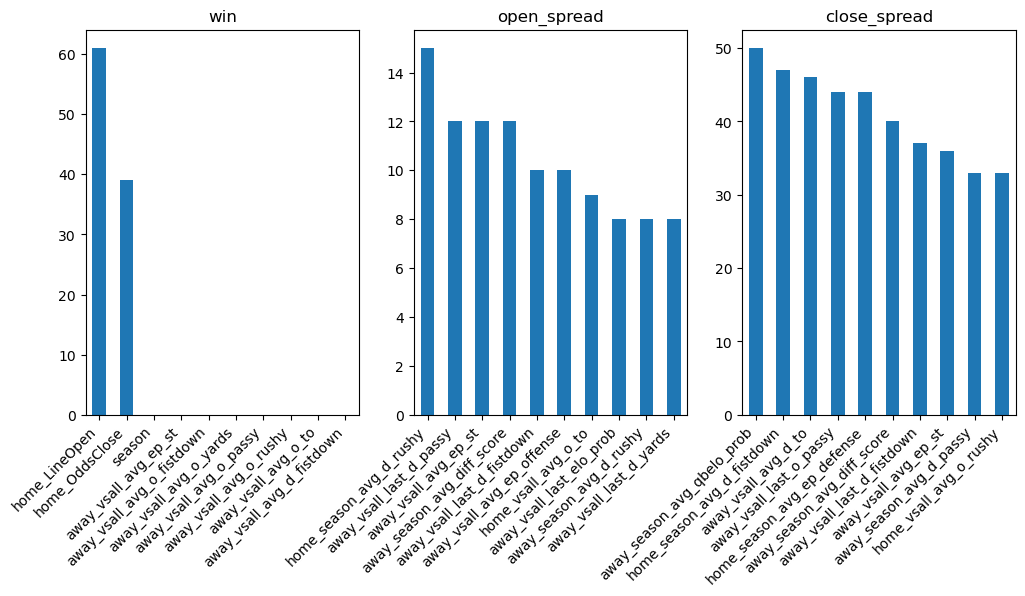

In [138]:
fig, axs = plt.subplots(1, len(Y.columns),figsize=(12, 5))
for i, res in enumerate(Y):
    fis[res].sort_values(ascending=False)[:10].plot(kind="bar", ax=axs[i])
    # Slant labels 45 degrees
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")
    axs[i].set_title(res)
plt.show()

### Model Fit Evaluation

Benter:
> The log likelihood function of equation (2) can be used to produce a measure of fit analogous to the R' of multiple linear regression (Equation 3). This pseudo-R*(I?) can be used to compare models and to assess the value of a particular model as a betfing tool. Each set of probability estimates, either the public's or those of a model, achiwe a certain $R^2$ ,defined as (Boltonand Chapman, 1986)
> $$ R^2 = 1 - \frac{L(model)}{L(1/N_j)}$$

> A heuristic measure of the potential profitability of a handicapping model, borne out in practice, is the amount by which its inclusion in the combined model ("C") along with the public probability estimate("P"_ causes the $R^2$ to increase over the value achieved by the public estimate alone:
> $$\Delta R^2 = R^2_C - R^2_P$$

NOTE: This is a version of the F-test for significance of extra regressors ([Wikipedia](https://en.wikipedia.org/wiki/F-test#Regression_problems)), if one took the true [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) for each model.

We have three models, so we can calculate three $R^2$'s. Let's try the `win` model first:
1. Establish the $1/N_j$ model. It will predict probabilities equal to the in-sample class fractions.


In [231]:
baseline_model_probs = Y_train.win.value_counts(normalize=True)
baseline_model_probs

 1.0    0.551212
-1.0    0.443315
 0.0    0.005473
Name: win, dtype: float64

In [232]:
baseline_LogL = np.log(baseline_model_probs[Y_test.win.values]).sum()
baseline_LogL

-219.79387848262888

In [233]:
win_probas = pd.DataFrame(probas.win).set_index(Y_test.index).rename(columns={0: 1, 1:0, 2: -1})
win_probas.head()

,1,0,-1
game_id,,,
2973,0.370493,0.005449,0.624057
2261,0.423968,0.005041,0.570991
2498,0.521644,0.005630,0.472726
2841,0.370493,0.005449,0.624057
3518,0.521644,0.005630,0.472726


In [234]:
Y_test.win.head()

game_id
2973   -1.0
2261    1.0
2498   -1.0
2841    1.0
3518   -1.0
Name: win, dtype: float64

In [235]:
win_model_probs = pd.Series({game_id: row[Y_test.win[game_id]] for game_id, row in win_probas.iterrows()})
win_model_probs


2973    0.624057
2261    0.423968
2498    0.472726
2841    0.370493
3518    0.472726
          ...   
3440    0.472726
3487    0.521644
3336    0.521644
3133    0.423968
2863    0.371679
Length: 320, dtype: float64

In [236]:
private_LogL = np.log(win_model_probs).sum()
private_LogL

-247.29784743861353

In [237]:
public_model_probas = pd.DataFrame().reindex_like(win_probas)
public_model_probas[1] = 1/ X_test.home_OddsClose
public_model_probas[-1] = 1/ X_test.away_OddsClose
public_model_probas[0] = 0  # TODO: Better choice?
public_model_probas = public_model_probas.div(public_model_probas.sum(axis=1), axis=0)  # Normalize to 1
public_model_probas.head()

,1,0,-1
game_id,,,
2973,0.681211,0.0,0.318789
2261,0.575864,0.0,0.424136
2498,0.521873,0.0,0.478127
2841,0.751721,0.0,0.248279
3518,0.341176,0.0,0.658824


In [238]:
public_model_probs = pd.Series({game_id: row[Y_test.win[game_id]] for game_id, row in public_model_probas.iterrows()})
public_LogL = np.log(public_model_probs).sum()
public_LogL

-195.98827647862436

In [239]:
public_R2 = 1 - (public_LogL / baseline_LogL)
private_R2 = 1 - (private_LogL / baseline_LogL)
public_R2, private_R2

(0.10830875804344098, -0.1251352819553544)

Very bad news indeed. But let's soldier on!

THINK: Why isn't the estimator incorporating the information from the public odds, if they are available as features?

TODO: Combine public and private estimates in a final prediction. 

## Bet sizing

### Single bet scenario

In [265]:
c = 0.06  # p hat
div = 20  # odds/dividend
er = c * div # expected return
ev = adv = er - 1  # advantage/expected value
pool = 100_000
vig = 0.0
wealth = pool / 2

In [266]:
benter_bet = 416

In [267]:
def breakeven_bet(pool, c, div, vig=0.0):
    return pool * (1 / (c * div) + vig - 1) / (1 - vig - 1/c)

In [268]:
max_bet = breakeven_bet(pool, c, div, vig)
max_bet

1063.8297872340422

In [269]:
def expected_profit(bet, c, div, pool, vig):
    div_pre = div
    div_post = (pool + bet) * (1 - vig) / (pool / div_pre + bet)
    return (c * div_post - 1) * bet

In [270]:
assert expected_profit(max_bet, c, div, pool, vig) == 0

In [271]:
bounds = (0, max_bet)
res = minimize_scalar(lambda bet: -expected_profit(bet, c, div, pool, vig), bounds=bounds)
bet_opt, exp_profit = res.x, -res.fun
bounds, bet_opt, exp_profit, res

((0, 1063.8297872340422),
 506.28267431220087,
 48.18856431397316,
  message: Solution found.
  success: True
   status: 0
      fun: -48.18856431397316
        x: 506.28267431220087
      nit: 10
     nfev: 10)

In [272]:
bets = np.linspace(*bounds, 100)
ep = [expected_profit(b, c, div, pool, vig) for b in bets]

In [273]:
expected_profit(bet_opt, c, div, pool, vig), exp_profit

(48.18856431397316, 48.18856431397316)

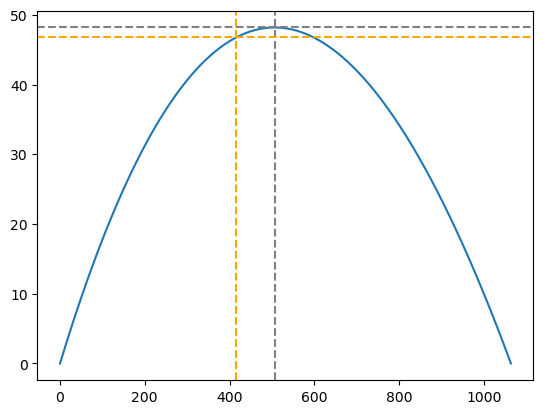

In [274]:
plt.plot(bets, ep)
# Draw a vertical line at `bet_opt`, with grey dashes
plt.axvline(bet_opt, color='grey', linestyle='--')
plt.axhline(exp_profit, color='grey', linestyle='--')
# Draw a vertical line at `benter_bet`, and a horizontal line at `expected_profit(benter_bet)`, both in orange and dashed
plt.axvline(benter_bet, color='orange', linestyle='--')
plt.axhline(expected_profit(benter_bet, c, div, pool, vig), color='orange', linestyle='--')

In [275]:
# https://en.wikipedia.org/wiki/Kelly_criterion
kelly_bet = (c * div - 1) / (div - 1)  # adv / net_div
kelly_bet * wealth

526.3157894736842

In [279]:
eps = pd.Series(
    Bundle(
        benter=expected_profit(benter_bet, c, div, pool, vig),
        kelly=expected_profit(kelly_bet * wealth, c, div, pool, vig),
        kelly_half=expected_profit(1 / 2 * kelly_bet * wealth, c, div, pool, vig),
        ep_max=expected_profit(bet_opt, c, div, pool, vig),
    )
)
bets = pd.Series(
    Bundle(
        benter=benter_bet,
        kelly=kelly_bet * wealth,
        kelly_half=kelly_bet / 2 * wealth,
        ep_max=bet_opt,
    )
)
pd.DataFrame({"bets": bets, "eps": eps}).round(2).sort_values(by="eps", ascending=False)

,bets,eps
ep_max,506.28,48.19
kelly,526.32,48.12
benter,416.00,46.77
kelly_half,263.16,37.63


In [281]:
wiki_kelly = c - (1 - c) / (div -1)

In [282]:
wiki_kelly, kelly_bet

(0.010526315789473682, 0.010526315789473682)

### Per-game betting

In [309]:
dividends = X_test[[c for c in X.columns if "Odds" in c]]

In [310]:
dividends.head()

,home_OddsOpen,home_OddsClose,home_LineOddsOpen,home_LineOddsClose,away_OddsOpen,away_OddsClose,away_LineOddsOpen,away_LineOddsClose
game_id,,,,,,,,
2973,1.404,1.432,1.952,1.934,3.200,3.06,1.952,1.970
2261,1.854,1.694,1.909,2.030,2.060,2.30,2.000,1.877
2498,2.310,1.869,1.909,1.925,1.689,2.04,2.000,1.980
2841,1.312,1.298,2.000,2.020,3.810,3.93,1.909,1.884
3518,2.100,2.800,1.860,1.900,1.760,1.45,1.950,1.900


In [311]:
probs = pd.DataFrame().reindex_like(dividends)

In [312]:
probs.home_OddsOpen = probs.home_OddsClose = probas.win[:, 0]
probs.away_OddsOpen = probs.away_OddsClose = probas.win[:, 2]  # col 1 is sign 0 or draw
probs.home_LineOddsOpen = probas.open_spread[:, 0]
probs.away_LineOddsOpen = probas.open_spread[:, 2]
probs.home_LineOddsClose = probas.close_spread[:, 0]
probs.away_LineOddsClose = probas.close_spread[:, 2]

probs.head().T.round(3)



game_id,2973,2261,2498,2841,3518
home_OddsOpen,0.370,0.424,0.522,0.370,0.522
home_OddsClose,0.370,0.424,0.522,0.370,0.522
home_LineOddsOpen,0.647,0.557,0.638,0.518,0.542
home_LineOddsClose,0.638,0.647,0.806,0.288,0.303
away_OddsOpen,0.624,0.571,0.473,0.624,0.473
away_OddsClose,0.624,0.571,0.473,0.624,0.473
away_LineOddsOpen,0.340,0.431,0.339,0.465,0.433
away_LineOddsClose,0.333,0.336,0.188,0.708,0.654


In [313]:
((probs * dividends) - 1).round(3).head(10).T

game_id,2973,2261,2498,2841,3518,3146,3685,2865,2772,3790
home_OddsOpen,-0.480,-0.214,0.205,-0.514,0.095,0.106,-0.347,-0.528,-0.537,2.521
home_OddsClose,-0.469,-0.282,-0.025,-0.519,0.461,0.226,-0.347,-0.516,-0.562,3.173
home_LineOddsOpen,0.263,0.064,0.218,0.036,0.009,-0.319,0.108,0.003,0.003,-0.057
home_LineOddsClose,0.235,0.314,0.551,-0.419,-0.424,-0.666,0.348,0.111,-0.236,0.378
away_OddsOpen,0.997,0.176,-0.202,1.378,-0.168,-0.146,0.513,1.609,1.783,-0.475
away_OddsClose,0.910,0.313,-0.036,1.453,-0.315,-0.210,0.513,1.403,2.501,-0.485
away_LineOddsOpen,-0.336,-0.138,-0.323,-0.112,-0.156,0.198,-0.235,-0.085,-0.072,-0.062
away_LineOddsClose,-0.344,-0.369,-0.627,0.334,0.242,0.638,-0.451,-0.170,0.155,-0.522


In [314]:
scorecard = pd.DataFrame().reindex_like(dividends)


In [315]:
scorecard.home_OddsOpen = scorecard.home_OddsClose = Y.win[X_test.index] == 1
scorecard.away_OddsOpen = scorecard.away_OddsClose = Y.win[X_test.index] == -1
scorecard.home_LineOddsOpen = Y.open_spread[X_test.index] == 1
scorecard.away_LineOddsOpen = Y.open_spread[X_test.index] == -1
scorecard.home_LineOddsClose = Y.close_spread[X_test.index] == 1
scorecard.away_LineOddsClose = Y.close_spread[X_test.index] == -1

scorecard.head(10).T

game_id,2973,2261,2498,2841,3518,3146,3685,2865,2772,3790
home_OddsOpen,False,True,False,True,False,False,True,True,True,False
home_OddsClose,False,True,False,True,False,False,True,True,True,False
home_LineOddsOpen,False,True,False,True,False,False,True,False,True,False
home_LineOddsClose,False,True,False,True,False,False,True,False,True,False
away_OddsOpen,True,False,True,False,True,True,False,False,False,True
away_OddsClose,True,False,True,False,True,True,False,False,False,True
away_LineOddsOpen,True,False,True,False,True,True,False,True,False,True
away_LineOddsClose,True,False,True,False,True,True,False,True,False,False


In [316]:
eps = 0.01
bets = ((probs * dividends - 1) > eps).astype(int)
bets.head(10).T

game_id,2973,2261,2498,2841,3518,3146,3685,2865,2772,3790
home_OddsOpen,0,0,1,0,1,1,0,0,0,1
home_OddsClose,0,0,0,0,1,1,0,0,0,1
home_LineOddsOpen,1,1,1,1,0,0,1,0,0,0
home_LineOddsClose,1,1,1,0,0,0,1,1,0,1
away_OddsOpen,1,1,0,1,0,0,1,1,1,0
away_OddsClose,1,1,0,1,0,0,1,1,1,0
away_LineOddsOpen,0,0,0,0,0,1,0,0,0,0
away_LineOddsClose,0,0,0,1,1,1,0,0,1,0


In [317]:
bets.values.sum()

1119

In [318]:
returns = (bets * dividends)[scorecard].fillna(0)
returns.sum().sum()

1078.661

In [319]:
rr = returns.T.reset_index(names="wager")
rr.groupby(rr.wager.str.contains("Open")).sum().sum(axis=1)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_56426/2956346380.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rr.groupby(rr.wager.str.contains("Open")).sum().sum(axis=1)


wager
False    578.356
True     500.305
dtype: float64

#### Calibration
Very common problem, should be alleviated with combined model, but still thorny.

NOTE: Talk about similar problem with impressions' buying, "winner's curse".

The following tables are similar in spirit to Tables 3 and 4 of Benter:

In [320]:
pd.DataFrame(Bundle(bet_won=scorecard[bets == 1].mean(), pred_prob=probs[bets == 1].mean())).round(3)

,bet_won,pred_prob
home_OddsOpen,0.374,0.522
home_OddsClose,0.408,0.522
home_LineOddsOpen,0.477,0.579
home_LineOddsClose,0.469,0.684
away_OddsOpen,0.317,0.601
away_OddsClose,0.317,0.599
away_LineOddsOpen,0.493,0.566
away_LineOddsClose,0.532,0.666


In [321]:
pd.DataFrame(Bundle(bet_won=scorecard[bets == 0].mean(), pred_prob=probs[bets == 0].mean())).round(3)

,bet_won,pred_prob
home_OddsOpen,0.674,0.404
home_OddsClose,0.664,0.402
home_LineOddsOpen,0.436,0.457
home_LineOddsClose,0.457,0.341
away_OddsOpen,0.593,0.473
away_OddsClose,0.600,0.474
away_LineOddsOpen,0.534,0.433
away_LineOddsClose,0.497,0.328


### Wagering Strategy
First, let's see if we can assume the wagering problem to be "sequential on the game IDs":

<Axes: xlabel='game_id', ylabel='date'>

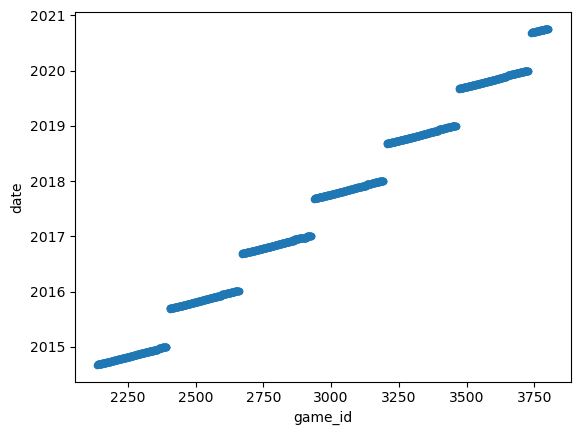

In [327]:
home[["Team", "Opponent", "date", "ts"]].reset_index().plot("game_id", "date", kind="scatter")

In [328]:
(home.date.sort_index().index.values, home.date.sort_values().index.values)

(array([2137, 2138, 2139, ..., 3799, 3800, 3801]),
 array([2137, 2150, 2149, ..., 3793, 3800, 3801]))

In [329]:
# Add <1s to date timestamp in order to break ties
ts_ = home.ts + home.index.values / 1e6
# Make sure now the games sorted by ID match the games sorted by tie-broken timestamps
assert np.all(home.sort_index().index.values == ts_.sort_values().index.values)


In [330]:
home.reset_index().groupby(["season"])[["date", "game_id"]].agg(["min", "max"])

date            game_id      
              min        max     min   max
season                                    
2014   2014-09-04 2014-12-28    2137  2392
2015   2015-09-10 2016-01-03    2404  2659
2016   2016-09-08 2017-01-01    2671  2926
2017   2017-09-07 2017-12-31    2938  3193
2018   2018-09-06 2018-12-30    3205  3460
2019   2019-09-05 2019-12-29    3472  3727
2020   2020-09-10 2020-10-05    3739  3801

#### Betting Options

> You can bet on NFL games through three main bet types: the moneyline, total points, and handicap (spread) markets.
> The moneyline market is a straightforward bet on the winner of the game.
> The points total market is betting whether the game will go over or under a certain amount of points.
> The handicap market is where one side is given a point advantage so that both teams are close to even money, and this is where the big action on NFL betting is.
Source: https://insights.matchbook.com/betting-strategy/how-to-bet-on-the-nfl/

- `OddsOpen, OddsClose` have no other qualifier, so I'm guessing these are the "moneyline odds".
- `LineOpen, LineClose` have both positive and negative values, and the away's LineX is always exactly negative the home's LineX, so we'll assume this is the spread line and beta ccordingly. A Line bet, then, is won when `team_score + line >= opp_score`.


#### Betting sequence
- `game_ids` are monotonically increasing with the game date, so we'll assume we can bet sequentially on every game of the test set, ordered by game_id.


#### Bet sizing
- This is a terminating (finite amount of bets) game, so Kelly doesn't apply directly. To maximise EV(log(wealth)), in each bet we should bet our entire fortune on the highest +EV bet, if there's any. This is very silly, so we'll treat it as a nonterminating game and bet using Kelly.

- For every game, there are eight possible bets: [home, away] * [money, spread] * [open, close]. Since they need to be made simultaneously _and are correlated_, the "(fractional) Kelly" criterion is not immediately suitable. Given that Benter goes for "1/2 - 1/3" fractional Kelly, we'll go for an "sum-fractional Kelly", in which if there are `K` bets on a given game with +EV, we bet $1/(2K)\ to\ 1/(3K)$ on each one. Heuristic AF, but reasonable.

- To avoid (heuristically) 0-EV bets, we'll actually bet only on bets with $EV>\epsilon$, and set `eps=0.01`.

- Also, the form of Kelly betting which is usually known (eq. 5 in Benter) ignores any effect of bet on payoff odds. This might be true for NFL games with huge pots and individual bettors, but not for an organization in parimutuel betting markets, so we'll assume a pot size of `pool` dollars and calculate a profit-maximizing bet accordingly, as Benter. (NOTE: Why the diff wth benter's???)

So, given parameters:
- `wealth`
- `pool`
- `c`
- `div0`: the dividend (or `Odds`) _right before betting_
- `take`
- `kelly_frac`

Our bet will be

`min(ep_max_bet, kelly_bet)`

where

`kelly_bet := kelly_frac * adv / (div - 1) * wealth`

and 

`ep_max_bet := argmax{bet} expected_profit(bet, pool, c, div0, take)`

and the expected profit is `bet * (c * div1 - 1)`, where `div1` are the new odds, after accounting for the bet made.

In [345]:
def breakeven_bet(pool, c, div, vig=0.0):
    return pool * (1 / (c * div) + vig - 1) / (1 - vig - 1/c)


def expected_profit(bet, c, div, pool, vig):
    div_pre = div
    div_post = (pool + bet) * (1 - vig) / (pool / div_pre + bet)
    return (c * div_post - 1) * bet

def kelly_wealth_frac(c, div):
    # https://en.wikipedia.org/wiki/Kelly_criterion
    return (c * div - 1) / (div - 1)


def epmax_bet(c, div, pool, vig, return_res=False):
    max_bet = breakeven_bet(pool, c, div, vig)
    if max_bet < 0:
        return None if return_res else np.nan, np.nan
    bounds = (0, max_bet)
    res = minimize_scalar(lambda bet: -expected_profit(bet, c, div, pool, vig), bounds=bounds)
    bet_opt, exp_profit = res.x, -res.fun
    return res if return_res else bet_opt, exp_profit

In [346]:
INITIAL_WEALTH = 1e6
EPS = 0.01  # epsilon
KELLY_RATIO = 1/2
POOL = 1e6
DEFAULT_TAKE = 0.05  # TODO: implement each game's take

In [347]:
INITIAL_WEALTH = 1e5
EPS = 0.01  # epsilon
KELLY_RATIO = 1/20
POOL = 1e6
DEFAULT_TAKE = 0.05
wealth = INITIAL_WEALTH
wealth_log = [wealth]
for game_id, divs in dividends.sort_index().head(200).iterrows():
    summary = pd.DataFrame(Bundle(
        divs=divs,
        probs=probs.loc[game_id],
        score=scorecard.loc[game_id],
    ))
    summary["exp_ret"] = summary.divs * summary.probs
    summary["place_bet"] = summary.exp_ret > (1 + eps)
    placed_bets = summary.place_bet.sum()
    summary["kwf"] = np.vectorize(kelly_wealth_frac)(summary.probs, summary.divs)
    summary["kelly_bet"] = summary.kwf * wealth * KELLY_RATIO / placed_bets
    summary["breakeven_bet"] = np.vectorize(breakeven_bet)(POOL, summary.probs, summary.divs, DEFAULT_TAKE)
    summary["epmax_bet"], summary["max_ep"] = np.where(
        summary.place_bet,
        np.vectorize(epmax_bet)(summary.probs, summary.divs, POOL, DEFAULT_TAKE),
        np.nan,
    )
    summary["final_bet"] = np.minimum(summary.epmax_bet, summary.kelly_bet).fillna(0)
    wealth -= summary.final_bet.sum()
    summary["revenue"] = np.where(summary.score, summary.divs * summary.final_bet, 0)
    # print(summary.round(2))
    wealth += summary.revenue.sum()
    wealth_log.append(wealth)
    # print(f"{game_id}: {wealth:.2f}")


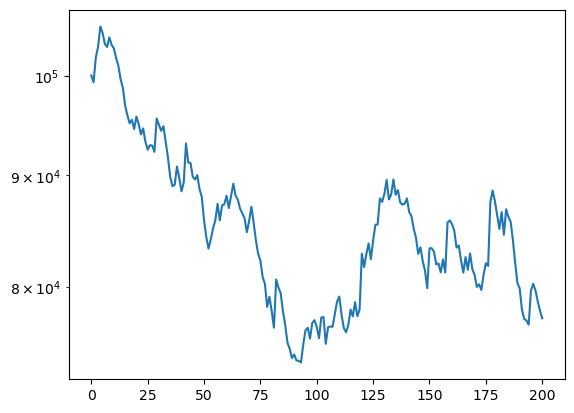

In [348]:
plt.plot(wealth_log)
plt.yscale("log")
plt.show()

```python
# Perfect information
    summary["final_bet"] = np.where(summary.score, 0.01 * wealth, 0)
# All bets
    summary["final_bet"] = 0.01 * wealth
# Bet only favorites
    summary["final_bet"] = np.where(summary.divs < 2, 0.01 * wealth, 0)
# Random Betting
    summary["final_bet"] = np.where(np.random.uniform(size=len(summary)) > 0.5, 0.01 * wealth, 0)
```

TODO: Train estimators per season, then predict & bet on the next season to simulate "real life".

TODO: Consider Utility Functions that take variance into account.

THINK: Does it make sense to consider estimator CV through some money-based decision function?

## Appendix: Some other stuff

### Better predicting